In [ ]:
import pandas as pd
import numpy as np
import gzip
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.ensemble import RUSBoostClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.metrics import geometric_mean_score
from google.colab import drive
from collections import Counter
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import BaseEnsemble
from sklearn.tree import BaseDecisionTree, DecisionTreeClassifier

from joblib import Parallel, delayed





In [ ]:
import imblearn
print(imblearn.__version__)


0.10.1


In [ ]:
drive.mount('/content/drive')

# Define the file path and data variable
file_path = r'/content/drive/MyDrive/Colab Notebooks/downsampled_1to100.xlsx'
data_loaded = False

# Check if the data has already been loaded
if 'data' in globals():
    data_loaded = True

if not data_loaded:
    # Load the gzipped file
    with gzip.open(file_path, 'rt') as f:
       data = pd.read_excel(file_path, header=0)

    data.columns = data.columns.str.strip()
    print(data.columns)


    # Drop redundant features
    data.drop(['Unnamed: 0', 'Flow ID', 'Source IP', 'Destination IP', 'Timestamp'], axis=1, inplace=True)
    constant_features = [col for col in data.columns if data[col].nunique() == 1]
    data.drop(constant_features, axis=1, inplace=True)

    # Handle NaNs and duplicates
    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)














Mounted at /content/drive
Index(['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max 

In [ ]:


#data = data.sample(frac=0.5, random_state=42)
print(data)

        Source Port  Destination Port  Protocol  Flow Duration  \
0               910             20073        17             48   
1               588             39159        17              2   
2               953             22161        17              1   
3               663             18811        17              1   
4               591              4168        17              1   
...             ...               ...       ...            ...   
343597            0                 0         0       19029778   
343598        57177                80         6         171239   
343599           80             57177         6            221   
343600        57225               443         6          62253   
343601            0                 0         0       19059205   

        Total Fwd Packets  Total Backward Packets  \
0                       2                       0   
1                       2                       0   
2                       2                       

In [ ]:
class_counts = data['Label'].value_counts()
single_class_samples = class_counts[class_counts <= 16].index
data = data[~data['Label'].isin(single_class_samples)]



# Encode non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=["SimillarHTTP"], drop_first=True)
# Handle infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Separate features and target
X = data.drop('Label', axis=1)
y = data['Label']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y)



# Apply scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Feature selection
selector = SelectKBest(f_classif, k=20)
X = selector.fit_transform(X, y)


In [ ]:
class_counts = np.bincount(y)
class_distribution = pd.DataFrame({'Class': le.inverse_transform(range(len(class_counts))), 'Count': class_counts})
print(class_distribution)

# Identify minority and majority classes
minority_class = class_distribution[class_distribution['Count'] == class_distribution['Count'].min()]['Class'].values[0]
majority_class = class_distribution[class_distribution['Count'] == class_distribution['Count'].max()]['Class'].values[0]
print(f"\nMinority class: {minority_class}")
print(f"Majority class: {majority_class}")


       Class   Count
0     BENIGN    3222
1  DrDoS_DNS  328691

Minority class: BENIGN
Majority class: DrDoS_DNS


In [ ]:
# Reduce the sample size for hyperparameter tuning
sample_size = 5000  # Further reduce the sample size
X_sample, y_sample = X[:sample_size], y[:sample_size]

# Define a wider parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),  # Wider range for n_estimators
    'learning_rate': uniform(0.01, 1.0),  # Wider range for learning_rate
    'estimator__max_depth': randint(1, 5)  # Wider range for max_depth
}

# Perform a more extensive RandomizedSearchCV
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42)
random_search = RandomizedSearchCV(adaboost, param_distributions=param_dist, scoring='f1_weighted', cv=3, n_iter=100, random_state=42, n_jobs=-1)
random_search.fit(X, y)

print("Best parameters for AdaBoost:", random_search.best_params_)
# Initialize classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "NaiveBayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=300, random_state=42),

}

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'base_estimator__max_depth': [1, 2, 3]
}
rusboost = RUSBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
grid_search = GridSearchCV(estimator=rusboost, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X, y)

#print("Best parameters for RUSBoost:", grid_search.best_params_)

param_grid = {
    'n_estimators': [10, 50, 100],
    'sampling_strategy': ['auto', 0.5, 0.75, 1.0]
}
easy_ensemble = EasyEnsembleClassifier(random_state=42)
grid_search = GridSearchCV(estimator=easy_ensemble, param_grid=param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X, y)
print("Best parameters for EasyEnsemble:", grid_search.best_params_)

# Resampling techniques
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)


# 10-fold Stratified Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store results
results = {
    "AdaBoostCost": [],
    "AdaC1": [],
    "CSB2": [],
    "SMOTEBoost": [],
    "RUSBoost": [],
    "UnderOverBagging": [],
    "EasyEnsemble": [],
    "WeightedDecisionTree": [],
    "RandomForest": {"rus": [], "ros": [], "smote": [], "adasyn": []},
    "KNN": {"rus": [], "ros": [], "smote": [], "adasyn": []},
    "DecisionTree": {"rus": [], "ros": [], "smote": [], "adasyn": []},
    "NaiveBayes": {"rus": [], "ros": [], "smote": [], "adasyn": []},
    "MLP": {"rus": [], "ros": [], "smote": [], "adasyn": []}
}




In [ ]:
# Calculate class frequencies
class_counts = np.bincount(y)
total_samples = len(y)
class_frequencies = class_counts / total_samples

# Create cost matrix based on inverse class frequencies
num_classes = len(class_counts)
cost_matrix = np.ones((num_classes, num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        if i != j:
            cost_matrix[i, j] = class_frequencies[i] / class_frequencies[j]

print("Cost Matrix:")
print(cost_matrix)

cost_matrix = np.np.array([
    [1, 5],
    [2, 1]
])


def compute_cost_adjusted_sample_weights(y, y_pred, sample_weight, cost_matrix):
    cost = np.zeros_like(sample_weight)
    for i, (true, pred) in enumerate(zip(y, y_pred)):
        true = np.clip(true, 0, cost_matrix.shape[0] - 1)
        pred = np.clip(pred, 0, cost_matrix.shape[1] - 1)
        if true < cost_matrix.shape[0] and pred < cost_matrix.shape[1]:
            cost[i] = cost_matrix[true, pred]
        else:
            cost[i] = 0
    sample_weight *= np.exp(cost)
    return sample_weight / np.sum(sample_weight)

Cost Matrix:
[[1.00000000e+00 9.80251969e-03]
 [1.02014587e+02 1.00000000e+00]]


In [ ]:
def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_results = {}
    for i in range(len(cm)):
        class_results[i] = {
            "correct": cm[i, i],
            "incorrect": np.sum(cm[i]) - cm[i, i]
        }
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "confusion_matrix": cm,
        "precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "gmean": geometric_mean_score(y_true, y_pred, average='weighted'),
        "class_results": class_results
    }

In [ ]:
def evaluate_model(train_index, test_index):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

    if len(np.unique(y_train)) != len(np.unique(y_test)):
        print("Skipping a fold due to mismatched class labels in y_train and y_test")
        return None

    fold_results = {
        "AdaBoostCost": [],
        "AdaC1": [],
        "CSB2": [],
        "SMOTEBoost": [],
        "RUSBoost": [],
        "UnderOverBagging": [],
        "EasyEnsemble": [],
        "WeightedDecisionTree": [],
        "RandomForest": {"rus": [], "ros": [], "smote": [], "adasyn": []},
        "KNN": {"rus": [], "ros": [], "smote": [], "adasyn": []},
        "DecisionTree": {"rus": [], "ros": [], "smote": [], "adasyn": []},
        "NaiveBayes": {"rus": [], "ros": [], "smote": [], "adasyn": []},
        "MLP": {"rus": [], "ros": [], "smote": [], "adasyn": []}
    }

    adacost = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=3),
        n_estimators=173,
        learning_rate=0.8387375091519294,
        algorithm="SAMME",
        random_state=42)
    sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
    adacost.fit(X_train, y_train, sample_weight=sample_weight)

    y_pred_adacost_test = adacost.predict(X_test)
    fold_results["AdaBoostCost"].append(calculate_metrics(y_test, y_pred_adacost_test))

    dt = DecisionTreeClassifier(random_state=42)
    balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
    param_grid_dt = dict(class_weight=balance)
    grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, n_jobs=-1, cv=3, scoring='f1_weighted')
    grid_search_dt.fit(X_train, y_train)
    best_dt = grid_search_dt.best_estimator_

    best_dt.fit(X_train, y_train)
    y_pred_dt_test = best_dt.predict(X_test)
    fold_results["WeightedDecisionTree"].append(calculate_metrics(y_test, y_pred_dt_test))

    param_grid_easy = {
        'n_estimators': (50, 500),
        'sampling_strategy': ['auto', 'not minority', 'all']
    }

    easy_ensemble = EasyEnsembleClassifier(random_state=42)
    random_search = RandomizedSearchCV(easy_ensemble, param_distributions=param_grid_easy, n_iter=50, scoring='f1_weighted', cv=3, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_easy_ensemble = random_search.best_estimator_

    y_pred_test = best_easy_ensemble.predict(X_test)
    fold_results["EasyEnsemble"].append(calculate_metrics(y_test, y_pred_test))

    rusboost = RUSBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        learning_rate=0.1,
        random_state=42)
    rusboost.fit(X_train, y_train)
    y_pred_rusboost_test = rusboost.predict(X_test)
    fold_results["RUSBoost"].append(calculate_metrics(y_test, y_pred_rusboost_test))

    under_over_bagging = BalancedBaggingClassifier(
        base_estimator=DecisionTreeClassifier(),
        sampling_strategy='auto',
        replacement=False,
        random_state=42
    )
    under_over_bagging.fit(X_train, y_train)
    y_pred_under_over_bagging_test = under_over_bagging.predict(X_test)
    fold_results["UnderOverBagging"].append(calculate_metrics(y_test, y_pred_under_over_bagging_test))

    sample_weight = np.ones(X_train.shape[0]) / X_train.shape[0]
    csb2 = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=50,
        learning_rate=1.0,
        algorithm='SAMME.R')
    for i in range(50):
        csb2.fit(X_train, y_train, sample_weight=sample_weight)
        y_pred = csb2.predict(X_train)
        sample_weight = compute_cost_adjusted_sample_weights(y_train, y_pred, sample_weight, cost_matrix)

    y_pred_csb2_test = csb2.predict(X_test)
    fold_results["CSB2"].append(calculate_metrics(y_test, y_pred_csb2_test))

    adac1 = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=87,
        learning_rate=0.4262213204002109,
        algorithm="SAMME",
        random_state=42
    )

    sample_weight = np.ones_like(y_train) / len(y_train)
    for iboost in range(adac1.n_estimators):
        adac1.fit(X_train, y_train, sample_weight=sample_weight)
        y_pred_adac1_train = adac1.predict(X_train)
        sample_weight = compute_cost_adjusted_sample_weights(y_train, y_pred_adac1_train, sample_weight, cost_matrix)

    y_pred_adac1_test = adac1.predict(X_test)
    fold_results["AdaC1"].append(calculate_metrics(y_test, y_pred_adac1_test))

    for clf_name, clf in classifiers.items():
        # Random Under-Sampling
        X_rus, y_rus = rus.fit_resample(X_train, y_train)
        clf.fit(X_rus, y_rus)
        y_pred_rus_test = clf.predict(X_test)
        fold_results[clf_name]["rus"].append(calculate_metrics(y_test, y_pred_rus_test))

        # Random Over-Sampling
        X_ros, y_ros = ros.fit_resample(X_train, y_train)
        clf.fit(X_ros, y_ros)
        y_pred_ros_test = clf.predict(X_test)
        fold_results[clf_name]["ros"].append(calculate_metrics(y_test, y_pred_ros_test))

        # SMOTE
        X_smote, y_smote = smote.fit_resample(X_train, y_train)
        clf.fit(X_smote, y_smote)
        y_pred_smote_test = clf.predict(X_test)
        fold_results[clf_name]["smote"].append(calculate_metrics(y_test, y_pred_smote_test))

        # ADASYN
        try:
            minority_class_count = np.min(np.bincount(y_train))
            n_neighbors = min(6, minority_class_count - 1)
            adasyn = ADASYN(n_neighbors=n_neighbors, random_state=42)
            X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
            clf.fit(X_adasyn, y_adasyn)
            y_pred_adasyn_test = clf.predict(X_test)
            fold_results[clf_name]["adasyn"].append(calculate_metrics(y_test, y_pred_adasyn_test))
        except RuntimeError as e:
            print(f"Skipping ADASYN for {clf_name} due to: {e}")

    adasmote = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=87,
        learning_rate=0.4262213204002109,
        random_state=42)
    X_smoteboost, y_smoteboost = smote.fit_resample(X_train, y_train)
    adasmote.fit(X_smoteboost, y_smoteboost)
    y_pred_smoteboost_test = adasmote.predict(X_test)
    fold_results["SMOTEBoost"].append(calculate_metrics(y_test, y_pred_smoteboost_test))

    gc.collect()
    return fold_results

In [ ]:

fold_results_list = Parallel(n_jobs=-1)(delayed(evaluate_model)(train_index, test_index) for train_index, test_index in skf.split(X, y))

# Combine the results from all folds

for train_index, test_index in skf.split(X, y):
    fold_results = evaluate_model(train_index, test_index)
    if fold_results is not None:
        for clf_name in fold_results.keys():
            for resampling_method in fold_results[clf_name].keys():
               results[clf_name][resampling_method].extend(fold_results[clf_name][resampling_method])


In [ ]:
def print_class_specific_results(results, clf_name, sampling_method):
    # Aggregate results
    if sampling_method:
        if results[clf_name][sampling_method]:
            print(f"\nResults for {clf_name} ({sampling_method}):")
            for metric in ["accuracy", "f1_score", "precision", "recall", "gmean"]:
                scores = [res[metric] for res in results[clf_name][sampling_method]]
                print(f"{metric.capitalize()}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            print("Class-specific results:")
            class_results_aggregate = {}
            for res in results[clf_name][sampling_method]:
                for cls, res_cls in res["class_results"].items():
                    if cls not in class_results_aggregate:
                        class_results_aggregate[cls] = {"correct": 0, "incorrect": 0}
                    class_results_aggregate[cls]["correct"] += res_cls["correct"]
                    class_results_aggregate[cls]["incorrect"] += res_cls["incorrect"]
            for cls, res_cls in class_results_aggregate.items():
                print(f"Class {cls}: Correct - {res_cls['correct']}, Incorrect - {res_cls['incorrect']}")
    else: # Handle cases without sampling methods
        if results[clf_name]:
            print(f"\nResults for {clf_name}:")
            for metric in ["accuracy", "f1_score", "precision", "recall", "gmean"]:
                scores = [res[metric] for res in results[clf_name]] # Access results directly
                print(f"{metric.capitalize()}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            class_results_aggregate = {}
            for res in results[clf_name]:
                for cls, res_cls in res["class_results"].items():
                    if cls not in class_results_aggregate:
                        class_results_aggregate[cls] = {"correct": 0, "incorrect": 0}
                    class_results_aggregate[cls]["correct"] += res_cls["correct"]
                    class_results_aggregate[cls]["incorrect"] += res_cls["incorrect"]
            for cls, res_cls in class_results_aggregate.items():
                print(f"Class {cls}: Correct - {res_cls['correct']}, Incorrect - {res_cls['incorrect']}")


# Classifiers to print results for
classifiers_to_print = [
    "AdaBoostCost", "CSB2", "WeightedDecisionTree", "RUSBoost",
    "UnderOverBagging", "SMOTEBoost", "AdaC1", "EasyEnsemble"
]

# Print results for each classifier
for clf_name in classifiers_to_print:
    print_class_specific_results(results, clf_name, "")

# Print results for each classifier and resampling method
sampling_methods = ["rus", "ros", "smote", "adasyn"]
for clf_name in classifiers.keys():
    for method in sampling_methods:
        print_class_specific_results(results, clf_name, method)



Results for AdaBoostCost:
Accuracy: 0.9999 ± 0.0000
F1_score: 0.9999 ± 0.0000
Precision: 0.9999 ± 0.0000
Recall: 0.9999 ± 0.0000
Gmean: 0.9995 ± 0.0010
Class 0: Correct - 3219, Incorrect - 3
Class 1: Correct - 328673, Incorrect - 18

Results for CSB2:
Accuracy: 0.1089 ± 0.2937
F1_score: 0.1036 ± 0.2960
Precision: 0.5306 ± 0.4320
Recall: 0.1089 ± 0.2937
Gmean: 0.1824 ± 0.2550
Class 0: Correct - 2879, Incorrect - 343
Class 1: Correct - 33281, Incorrect - 295410

Results for WeightedDecisionTree:
Accuracy: 1.0000 ± 0.0000
F1_score: 1.0000 ± 0.0000
Precision: 1.0000 ± 0.0000
Recall: 1.0000 ± 0.0000
Gmean: 0.9997 ± 0.0009
Class 0: Correct - 3220, Incorrect - 2
Class 1: Correct - 328688, Incorrect - 3

Results for RUSBoost:
Accuracy: 0.9997 ± 0.0001
F1_score: 0.9997 ± 0.0001
Precision: 0.9997 ± 0.0001
Recall: 0.9997 ± 0.0001
Gmean: 0.9995 ± 0.0006
Class 0: Correct - 3220, Incorrect - 2
Class 1: Correct - 328598, Incorrect - 93

Results for UnderOverBagging:
Accuracy: 0.9997 ± 0.0001
F1_scor

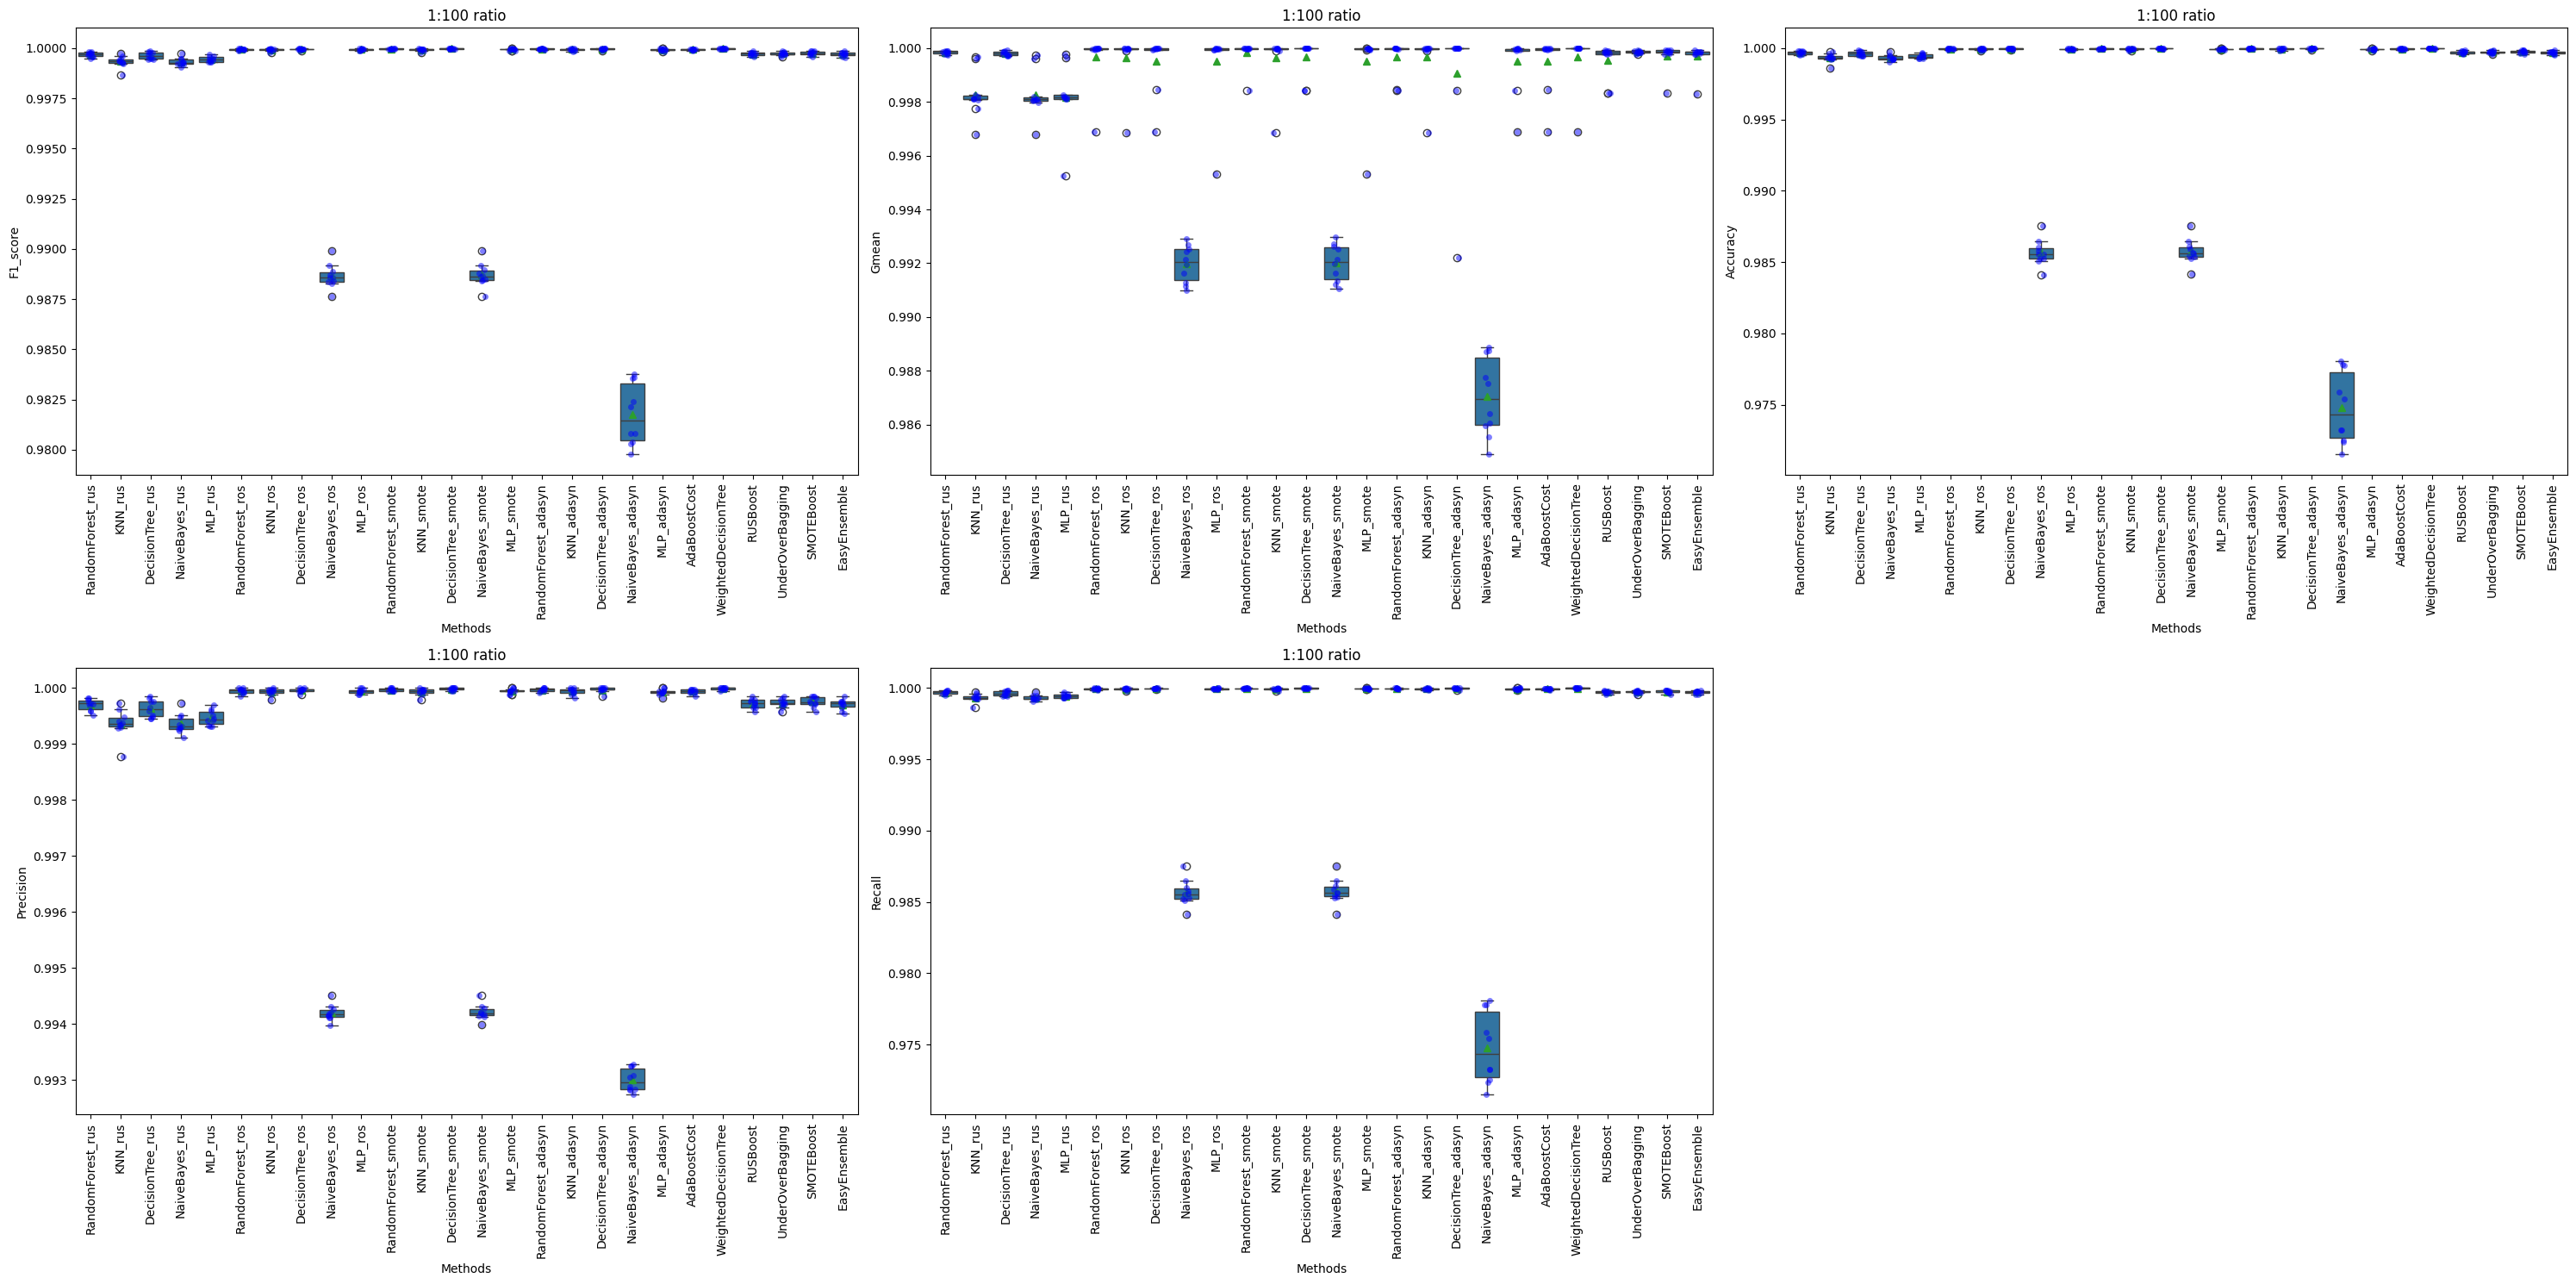

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
classifiers = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "NaiveBayes": GaussianNB(),
    "MLP": MLPClassifier(max_iter=300, random_state=42),

}
def plot_all_models_box_plot(results, classifiers, metrics):
    sampling_methods = ["rus", "ros", "smote", "adasyn"]

    fig, axes = plt.subplots(2, 3, figsize=(30, 15))  # 2 rows, 3 columns for subplots
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        data = []
        for method in sampling_methods:
            for clf_name in classifiers.keys():
                if method in results[clf_name]:
                    for res in results[clf_name][method]:
                        if res[metric] >= 0.4:  # Filter scores less than 0.4
                            data.append({
                                "Classifier": clf_name + "_" + method,
                                "Score": res[metric],
                                "Metric": metric
                            })

        for clf_name in ["AdaBoostCost", "WeightedDecisionTree", "RUSBoost", "UnderOverBagging", "SMOTEBoost", "EasyEnsemble"]:
            if clf_name in results:
                for res in results[clf_name]:
                    if res[metric] >= 0.4:  # Filter scores less than 0.4
                        data.append({
                            "Classifier": clf_name,
                            "Score": res[metric],
                            "Metric": metric
                        })

        df = pd.DataFrame(data)

        if not df.empty:
            sns.boxplot(x="Classifier", y="Score", data=df, ax=axes[idx], showmeans=True)
            sns.stripplot(x="Classifier", y="Score", data=df, ax=axes[idx], jitter=True, color='blue', alpha=0.5)

            axes[idx].set_title(f"1:100 ratio")
            axes[idx].set_xlabel('Methods')
            axes[idx].set_ylabel(metric.capitalize())
            axes[idx].tick_params(axis='x', rotation=90)
        else:
            axes[idx].set_title(f"No data for {metric}")
            axes[idx].axis('off')

    # Hide any unused subplots if the number of metrics is less than 6
    for idx in range(len(metrics), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage (requires `results` and `classifiers` to be defined)
# Define metrics
metrics = ["f1_score", "gmean", "accuracy", "precision", "recall"]

# Plot results for all models
plot_all_models_box_plot(results, classifiers, metrics)
